In [1]:
import numpy as np
import pandas as pd

from skimage import io
from skimage import color
import skimage.measure
import cv2
from IPython.display import SVG

import face_recognition

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches

import tensorflow as tf
from keras import layers
import keras
from keras.utils import plot_model
from keras import backend as K

import random
import math
import os

import string
import time
import re
import nltk
# Import WordNetLemmatizer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/errorgorn/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
tf.get_logger().setLevel('ERROR')

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

## NLP

In [5]:
nltk.download('stopwords') 

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/errorgorn/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/errorgorn/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [7]:
def get_wordnet_pos(word): # taken from https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

pattern = re.compile("【|】|\[|\]")

# Initalize TweetTokenizer
tt = TweetTokenizer()

# English stop words
english_stops = stopwords.words('english')

# Printable characters
printable = set(string.printable)

# Instantiate the WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

def editString(title):
    title = pattern.sub("|",title)                             # replace square brackets with |
    title = "".join(filter(lambda x: x in printable, title))   # remove non printable characters

    tokens = tt.tokenize(text=title)                           # tokenize string
    
    # Convert the tokens into lowercase: lower_tokens, indicate if capital
    tokens_edited = [t.lower() + " [&CAP] " if (t.upper() == t and t.isalpha() and len(t) > 1) else t.lower() for t in tokens ]

    # Remove all stop words: no_stops
    no_stops = [t for t in tokens_edited if t not in english_stops]

    # Lemmatize all tokens into a new list: lemmatized
    lemmatized = [wordnet_lemmatizer.lemmatize(t, get_wordnet_pos(t)) for t in no_stops]

    return " ".join(lemmatized)


## Read Dataset

In [8]:
def get_img(id):
    return mpimg.imread('thumbs/'+id+'.jpg')

In [9]:
def get_face(id,num):
    if (os.path.isfile('faces/'+id+'_'+str(num)+'.jpg')): return mpimg.imread('faces/'+id+'_'+str(num)+'.jpg')
    else: return np.ones((96,96,3),dtype='uint8')*128

In [10]:
def get_df(file):
    df=pd.read_csv(file,index_col=0)
    df=df.T
    df=df.reset_index(drop=True)
    
    #nlp
    df["title"]=df["title"].apply(editString)
    df["clickbait"]=df["clickbait"].astype(int)
    
    return df

In [11]:
df=get_df('metadata_alpha.csv')
df2=get_df('metadata_beta0.csv')
df3=get_df('metadata_beta1.csv')

In [12]:
print(df2[df2["id"]=="kJQP7kiw5Fk"])
print(df2[df2["id"]=="R_oVq2hCy70"])
print(df3[df3["id"]=="SlPhMPnQ58k"])

                                        title                views  \
62   luis fonsi - despacito ft . daddy yankee  7,293,692,975 views   
137  luis fonsi - despacito ft . daddy yankee  7,293,692,975 views   

                likes            dislikes  \
62   43,569,832 likes  4,990,350 dislikes   
137  43,569,842 likes  4,990,351 dislikes   

                                                  desc           id  clickbait  
62   “Despacito” disponible ya en todas las platafo...  kJQP7kiw5Fk          0  
137  “Despacito” disponible ya en todas las platafo...  kJQP7kiw5Fk          0  
                      title          views        likes      dislikes  \
128  migrant flee guatemala  132,871 views  2,510 likes  337 dislikes   

                                                  desc           id  clickbait  
128  ABC News’ Marcus Moore reports from Guatemala ...  R_oVq2hCy70          0  
                                    title              views            likes  \
35   maroon 5 - memo

In [13]:
df_m=pd.concat([df,df2.drop([128,137]),df3.drop([35,129])])
df_m=df_m.set_index("id")
df_m

,title,views,likes,dislikes,desc,clickbait
id,,,,,,
K15jFOVrAy4,"veteran ' voice 2020 : general joseph votel , ...","22,540 views",92 likes,28 dislikes,"Veterans served their nation selflessly, but s...",0
lG3PEdw0xrU,make tandoori chicken,"1,724,176 views","93,482 likes","7,647 dislikes",Today I show you how to make authentic Tandoor...,1
0vUgGSLTtOg,25 airbag rainbow explosion 4k - slow mo guy,"6,431,213 views","185,758 likes","1,712 dislikes",Sometimes ideas get too big for our backyard s...,0
d17H1uhfYjw,hunt secret [&CAP] megalodon [&CAP] boss [&C...,"457,053 views","12,111 likes",386 dislikes,"If you enjoyed this video, watch more here: ht...",1
KTF1Nqvl8ug,maroon 5 - wanna know ( behind scene ),"1,050,911 views","27,807 likes",287 dislikes,"Buy “Don't Wanna Know"" ft. Kendrick LaMar now....",0
...,...,...,...,...,...,...
pXDvuUC9l7A,fast way get experience minecraft,"579,568 views","10,809 likes",575 dislikes,I'm on insta rn 📷 : http://www.instagram.com/f...,0
OhTBAr5pADg,union [&CAP] ! ! 1258pp pp [&CAP] world [&CA...,"163,818 views","12,015 likes",65 dislikes,해냈다,0
Xw_NNKpGobE,peppa pig official channel - fun snow ( clip ),"143,685,284 views",no like count,no dislike count,☆ Subscribe for more videos: http://bit.ly/Pep...,0


In [14]:
s,s2,s3=df["id"],df2["id"],df3["id"]

## More NLP

In [15]:
titles=df["title"]

In [16]:
titles

0       veteran ' voice 2020 : general joseph votel , ...
1                                   make tandoori chicken
2            25 airbag rainbow explosion 4k - slow mo guy
3       hunt secret [&CAP]  megalodon [&CAP]  boss [&C...
4                  maroon 5 - wanna know ( behind scene )
                              ...                        
9734    maroon 5 - pepsi super bowl liii [&CAP]  halft...
9735    * new [&CAP]  * fortnite [&CAP]  nuke [&CAP]  ...
9736     spraying [&CAP]  skunk [&CAP]  prank [&CAP]  ! !
9737    reacting [&CAP]  to [&CAP]  the [&CAP]  old [&...
9738                                  birthday faze house
Name: title, Length: 9739, dtype: object

In [17]:
# Model constants
max_features = 10000
embedding_dim = 32
sequence_length = 300

# Instantiate our text vectorization layer. 
# Map strings to integers
# Explicit maximum sequence length because CNN does not support ragged sequence
vectorize_layer = TextVectorization(
    standardize = None,
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length,
)

# Adapt layer to training set to set dictionary
vectorize_layer.adapt(titles.to_numpy())

In [18]:
def vectorize_text(text):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text)

In [19]:
vectorize_text("fortnite gaming") 

<tf.Tensor: shape=(1, 300), dtype=int64, numpy=
array([[ 11, 894,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
   

## Visualization of Thumbnails

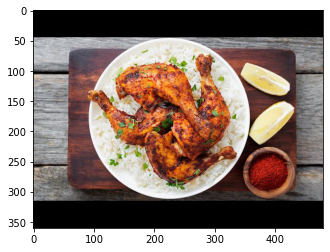

In [20]:
plt.imshow(get_img(df["id"][1])) #nice chicken

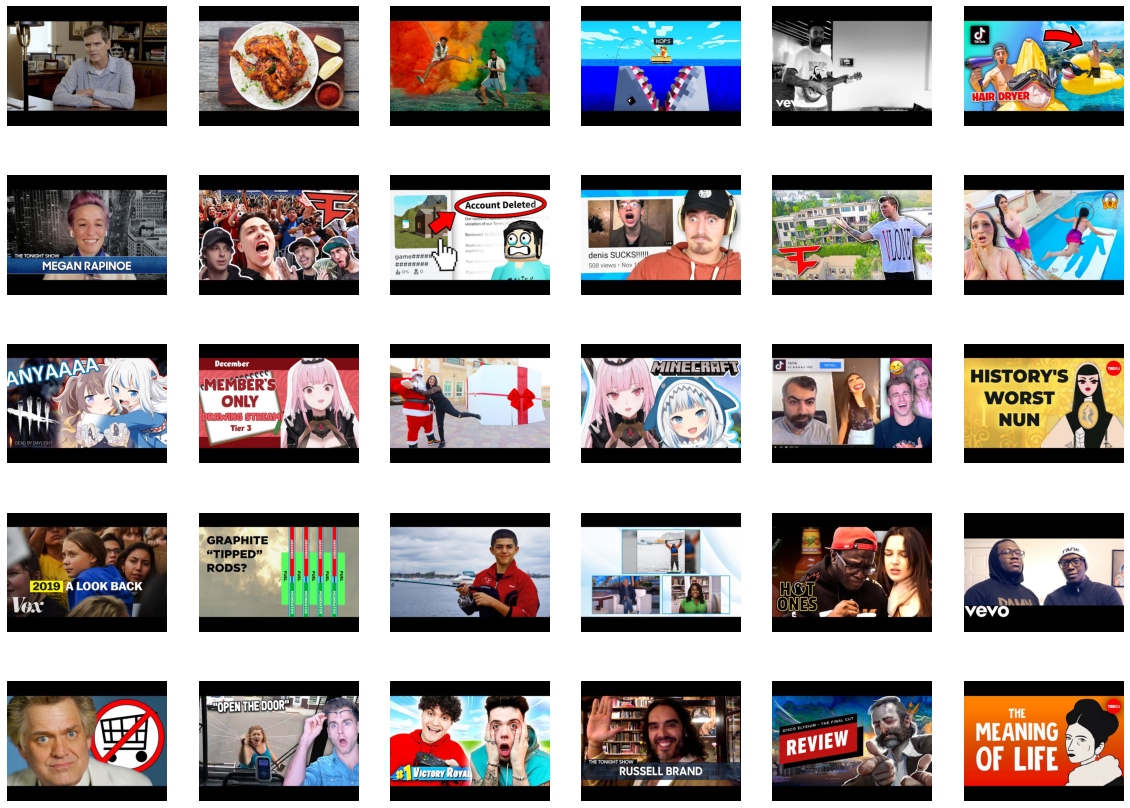

In [21]:
fig,axs=plt.subplots(5,6,figsize=(20,15))

for x in axs.ravel():
    x.axis('off')

for i in range(5):
    for j in range(6):
        axs[i,j].imshow(get_img(df["id"][i*6+j]))

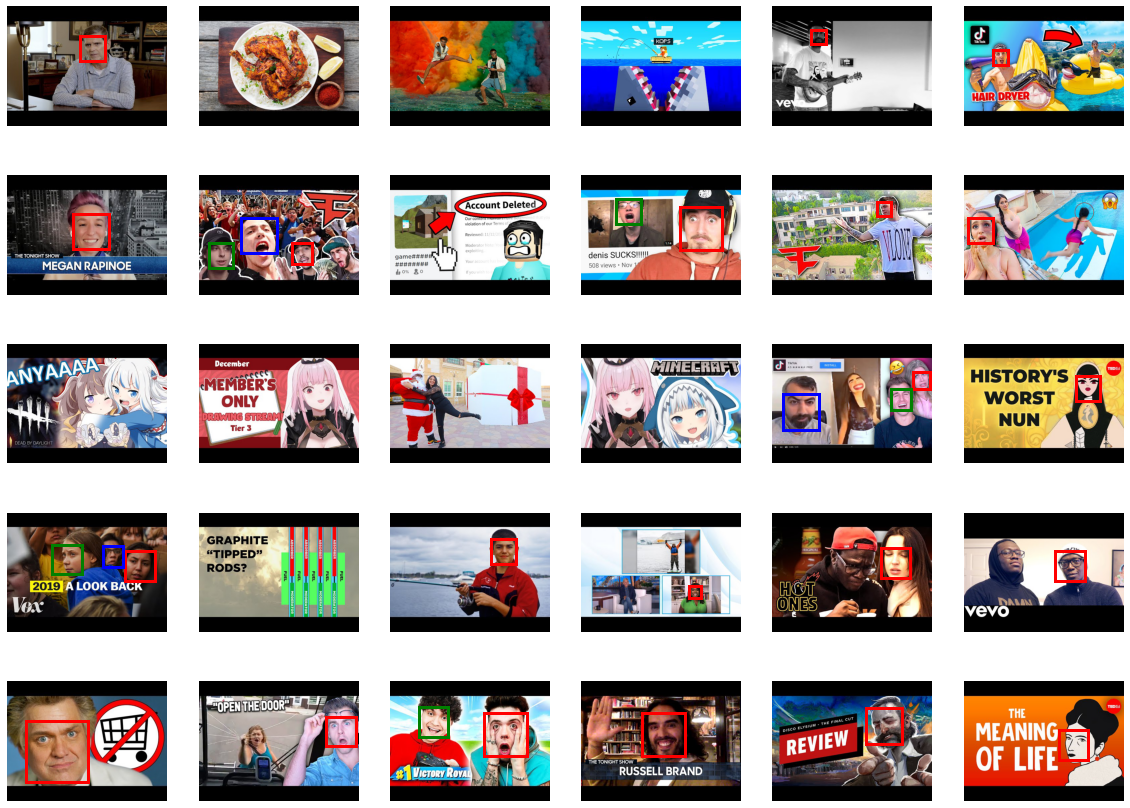

In [22]:
fig,axs=plt.subplots(5,6,figsize=(20,15))

for x in axs.ravel():
    x.axis('off')

for i in range(5):
    for j in range(6):
        img=get_img(df["id"][i*6+j])
        axs[i,j].imshow(img)
        
        locs=face_recognition.face_locations(img)
        
        for x in range(min(3,len(locs))):
            t,r,b,l=locs[x]
            
            rect=patches.Rectangle((l,t),r-l,b-t,linewidth=3,edgecolor="rgb"[x],facecolor='none')
            axs[i,j].add_patch(rect)

## Autoencoders

In [23]:
def encoder(t,b,l,r):
    tf.keras.backend.clear_session() #prevent high mem usage
    
    n,m=b-t,r-l
    
    # read faces from files
    
    #blank image here (since we will have to process blank images later)
    faces=[np.ones(shape=(n*m,))*0.5]
    
    for file in os.listdir("faces"):
        face=mpimg.imread('faces/'+file)[:,:,0]
        face=cv2.resize(face,(96,96))
        face=face[t:b,l:r].reshape(-1)
        face=(face-face.mean())/(face.std()*3)+0.5
        faces.append(face.reshape(-1)) #flatten
    
    faces=np.array(faces)
        
    #build autoencoder
    #it is actually just a single dense layer
    
    input_encoder=layers.Input((n*m,))
    
    #encoder
    encoded=layers.Dense(16,activation='sigmoid')(input_encoder) #latent space of 4

    encoder=keras.Model(
        inputs=[input_encoder],
        outputs=[encoded],
    )
    
    #decoder
    decoded=layers.Dense(n*m,activation='sigmoid')(encoded)

    train=keras.Model(
        inputs=[input_encoder],
        outputs=[decoded],
    )
    
    #train the autoencoder
    train.compile(
      optimizer="adam",
      loss="mean_squared_error",
    )
    
    #do 100 epochs
    train.fit(faces,faces,validation_split=0.2,epochs=20,batch_size=8,steps_per_epoch=1000)
    
    #display some examples of autoencoder
    fig,axs=plt.subplots(6,17,figsize=(17,6))
    
    for x in axs.ravel():
        x.axis('off')

    pred=train.predict(faces[:17])
    pred2=encoder.predict(faces[:17])

    for i in range(17):
        axs[0,i].imshow(faces[i].reshape(n,m)) #in
        axs[2,i].imshow(pred[i].reshape(n,m)) #out
        axs[1,i].imshow(pred2[i].reshape(4,4)) #latent space
        
    #get decoder
    train.get_weights()
    
    inp=layers.Input(16)
    dense=layers.Dense(n*m)(inp)
    
    decoder=keras.Model(
        inputs=[inp],
        outputs=[dense],
    )
    decoder.set_weights(train.get_weights()[2:])
    
    temp=np.zeros(shape=(17,16))
    for i in range(16): temp[i+1][i]=1
    
    #show each parameter of the latent layer
    pred=decoder.predict(temp)
    
    for i in range(17):
        axs[5,i].imshow(pred[i].reshape(n,m)) #out
        axs[4,i].imshow(temp[i].reshape(4,4)) #latent space
    
    #return encoder and converter for use later
    return encoder

Epoch 1/20
1000/1000 [==============================] - 2s 1ms/step - loss: 0.0801 - val_loss: 0.0554
Epoch 2/20
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0515 - val_loss: 0.0457
Epoch 3/20
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0434 - val_loss: 0.0412
Epoch 4/20
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0390 - val_loss: 0.0381
Epoch 5/20
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0365 - val_loss: 0.0356
Epoch 6/20
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0348 - val_loss: 0.0343
Epoch 7/20
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0331 - val_loss: 0.0329
Epoch 8/20
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0319 - val_loss: 0.0322
Epoch 9/20
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0308 - val_loss: 0.0311
Epoch 10/20
1000/1000 [==============================] - 1s 1ms/step - loss: 0.030

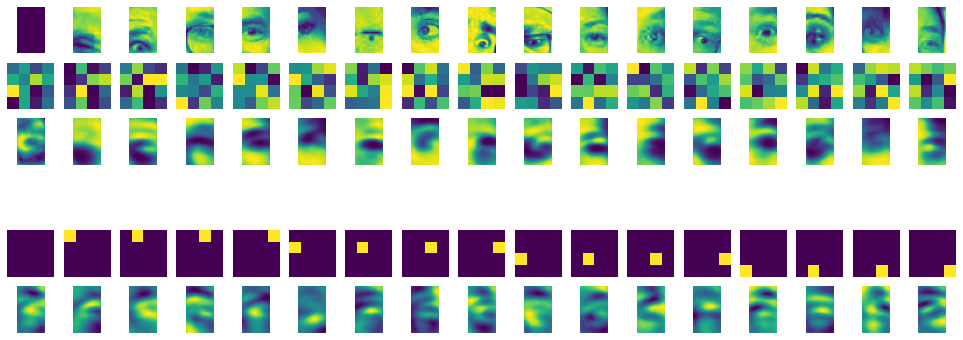

In [24]:
encode_eye=encoder(4,44,56,80)

Epoch 1/20
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0901 - val_loss: 0.0662
Epoch 2/20
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0633 - val_loss: 0.0587
Epoch 3/20
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0569 - val_loss: 0.0543
Epoch 4/20
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0532 - val_loss: 0.0511
Epoch 5/20
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0500 - val_loss: 0.0482
Epoch 6/20
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0476 - val_loss: 0.0466
Epoch 7/20
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0454 - val_loss: 0.0448
Epoch 8/20
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0440 - val_loss: 0.0445
Epoch 9/20
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0436 - val_loss: 0.0431
Epoch 10/20
1000/1000 [==============================] - 1s 1ms/step - loss: 0.042

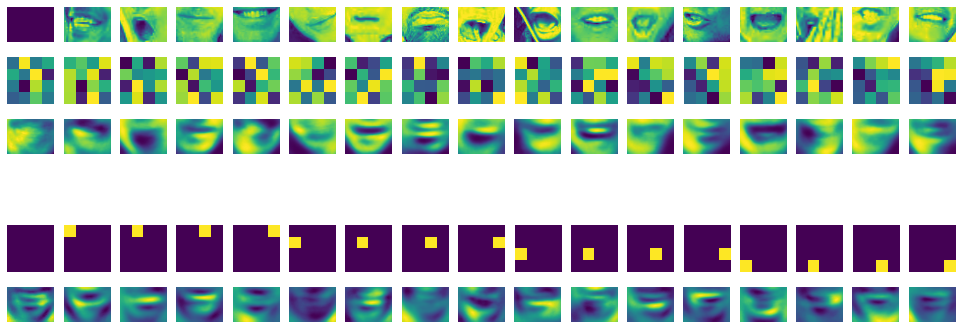

In [25]:
encode_mouth=encoder(60,96,24,72)

## Process Dataset 

In [26]:
def get_io(s):
    thumb=[]
    titles=[]
    eyes=[]
    mouths=[]
    ans=[]

    for id in s:
        img=get_img(id)[44:314]
        thumb.append(img)
        
        vec=vectorize_text(df_m["title"][id])
        titles.append(vec)
        
        img=get_face(id,0)[:,:,0]
        img=cv2.resize(img,(96,96))
        
        eye=img[4:44,56:80].reshape(-1)
        if (eye.std()!=0): eye=(eye-eye.mean())/(eye.std()*3)+0.5 #normalize with mean 0.5 and 1/3 std
        eyes.append(encode_eye(eye.reshape(1,-1)))
        
        mouth=img[60:96,24:72].reshape(-1)
        if (mouth.std()!=0): mouth=(mouth-mouth.mean())/(mouth.std()*3)+0.5 #normalize with mean 0.5 and 1/3 std
        mouths.append(encode_mouth(mouth.reshape(1,-1)))
        
        ans.append(df_m["clickbait"][id])
        
    X={
        "thumb":np.array(thumb),
        "title":np.array(titles).reshape(-1,300),
        "eye":np.array(eyes).reshape(-1,16),
        "mouth":np.array(mouths).reshape(-1,16)
    }
    
    y=np.array(ans).reshape(-1,1).astype(int)
    
    return X,y

In [27]:
X_train,y_train=get_io(s)

In [30]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

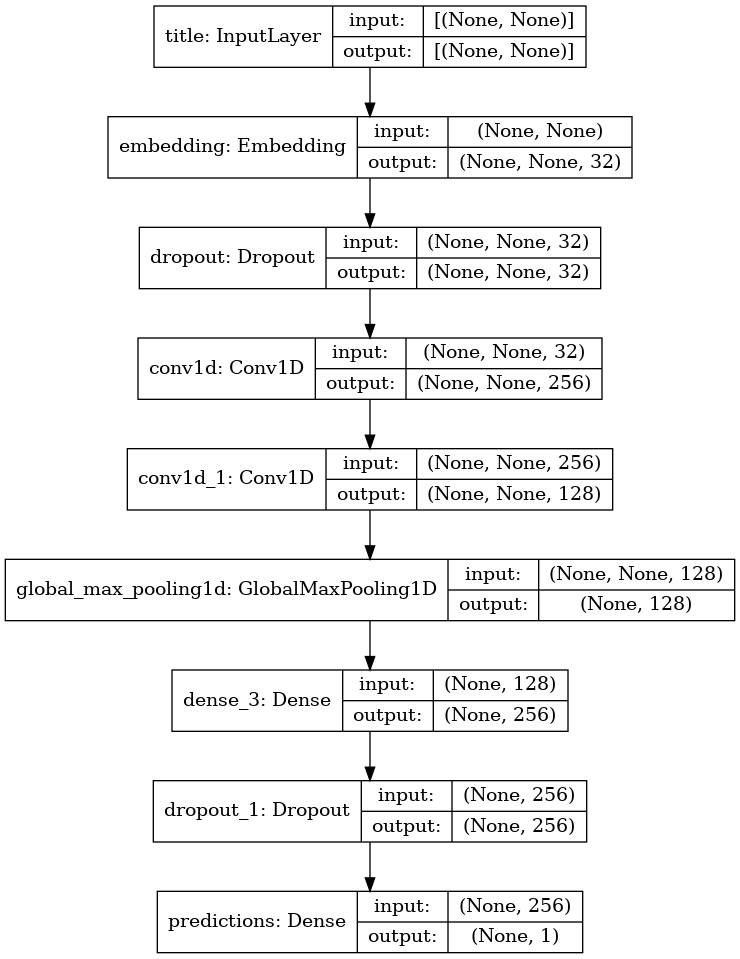

In [29]:
# A integer input for vocab indices.
inputs = tf.keras.Input(shape=(None,), dtype="int64",name="title")

# Next, we add a layer to map those vocab indices into a space of dimensionality
# 'embedding_dim'.
x = layers.Embedding(max_features, embedding_dim)(inputs)
x = layers.Dropout(0.7)(x)

# Conv1D + global max pooling
x = layers.Conv1D(256, 7, padding="valid", activation="relu", strides=2)(x)
x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=2)(x)
x = layers.GlobalMaxPooling1D()(x)

# We add a vanilla hidden layer:
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)

# We project onto a single unit output layer, and squash it with a sigmoid:
predictions = layers.Dense(1, activation="sigmoid", name="predictions")(x)

model = tf.keras.Model([inputs], predictions)

# Compile the model with binary crossentropy loss and an adam optimizer.
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["acc", precision_m, recall_m, f1_m])
plot_model(model,show_layer_names=1,show_shapes=True)

In [30]:
tf.keras.backend.clear_session()
model.fit(x=X_train,y=y_train,validation_split=0.2,
              epochs=10,batch_size=8)

Epoch 1/10


/home/errorgorn/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:592: UserWarning: Input dict contained keys ['thumb', 'eye', 'mouth'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


974/974 [==============================] - 23s 15ms/step - loss: 0.4666 - acc: 0.7481 - precision_m: 0.7444 - recall_m: 0.7084 - f1_m: 0.6869 - val_loss: 0.2142 - val_acc: 0.9132 - val_precision_m: 0.9377 - val_recall_m: 0.8591 - val_f1_m: 0.8818
Epoch 2/10
974/974 [==============================] - 5s 5ms/step - loss: 0.1952 - acc: 0.9225 - precision_m: 0.9137 - recall_m: 0.8746 - f1_m: 0.8787 - val_loss: 0.1928 - val_acc: 0.9240 - val_precision_m: 0.9421 - val_recall_m: 0.8764 - val_f1_m: 0.8949
Epoch 3/10
974/974 [==============================] - 5s 5ms/step - loss: 0.1302 - acc: 0.9473 - precision_m: 0.9493 - recall_m: 0.9141 - f1_m: 0.9212 - val_loss: 0.2088 - val_acc: 0.9240 - val_precision_m: 0.9491 - val_recall_m: 0.8761 - val_f1_m: 0.8987
Epoch 4/10
974/974 [==============================] - 5s 5ms/step - loss: 0.1067 - acc: 0.9551 - precision_m: 0.9414 - recall_m: 0.9249 - f1_m: 0.9235 - val_loss: 0.2111 - val_acc: 0.9286 - val_precision_m: 0.9215 - val_recall_m: 0.9088 - va

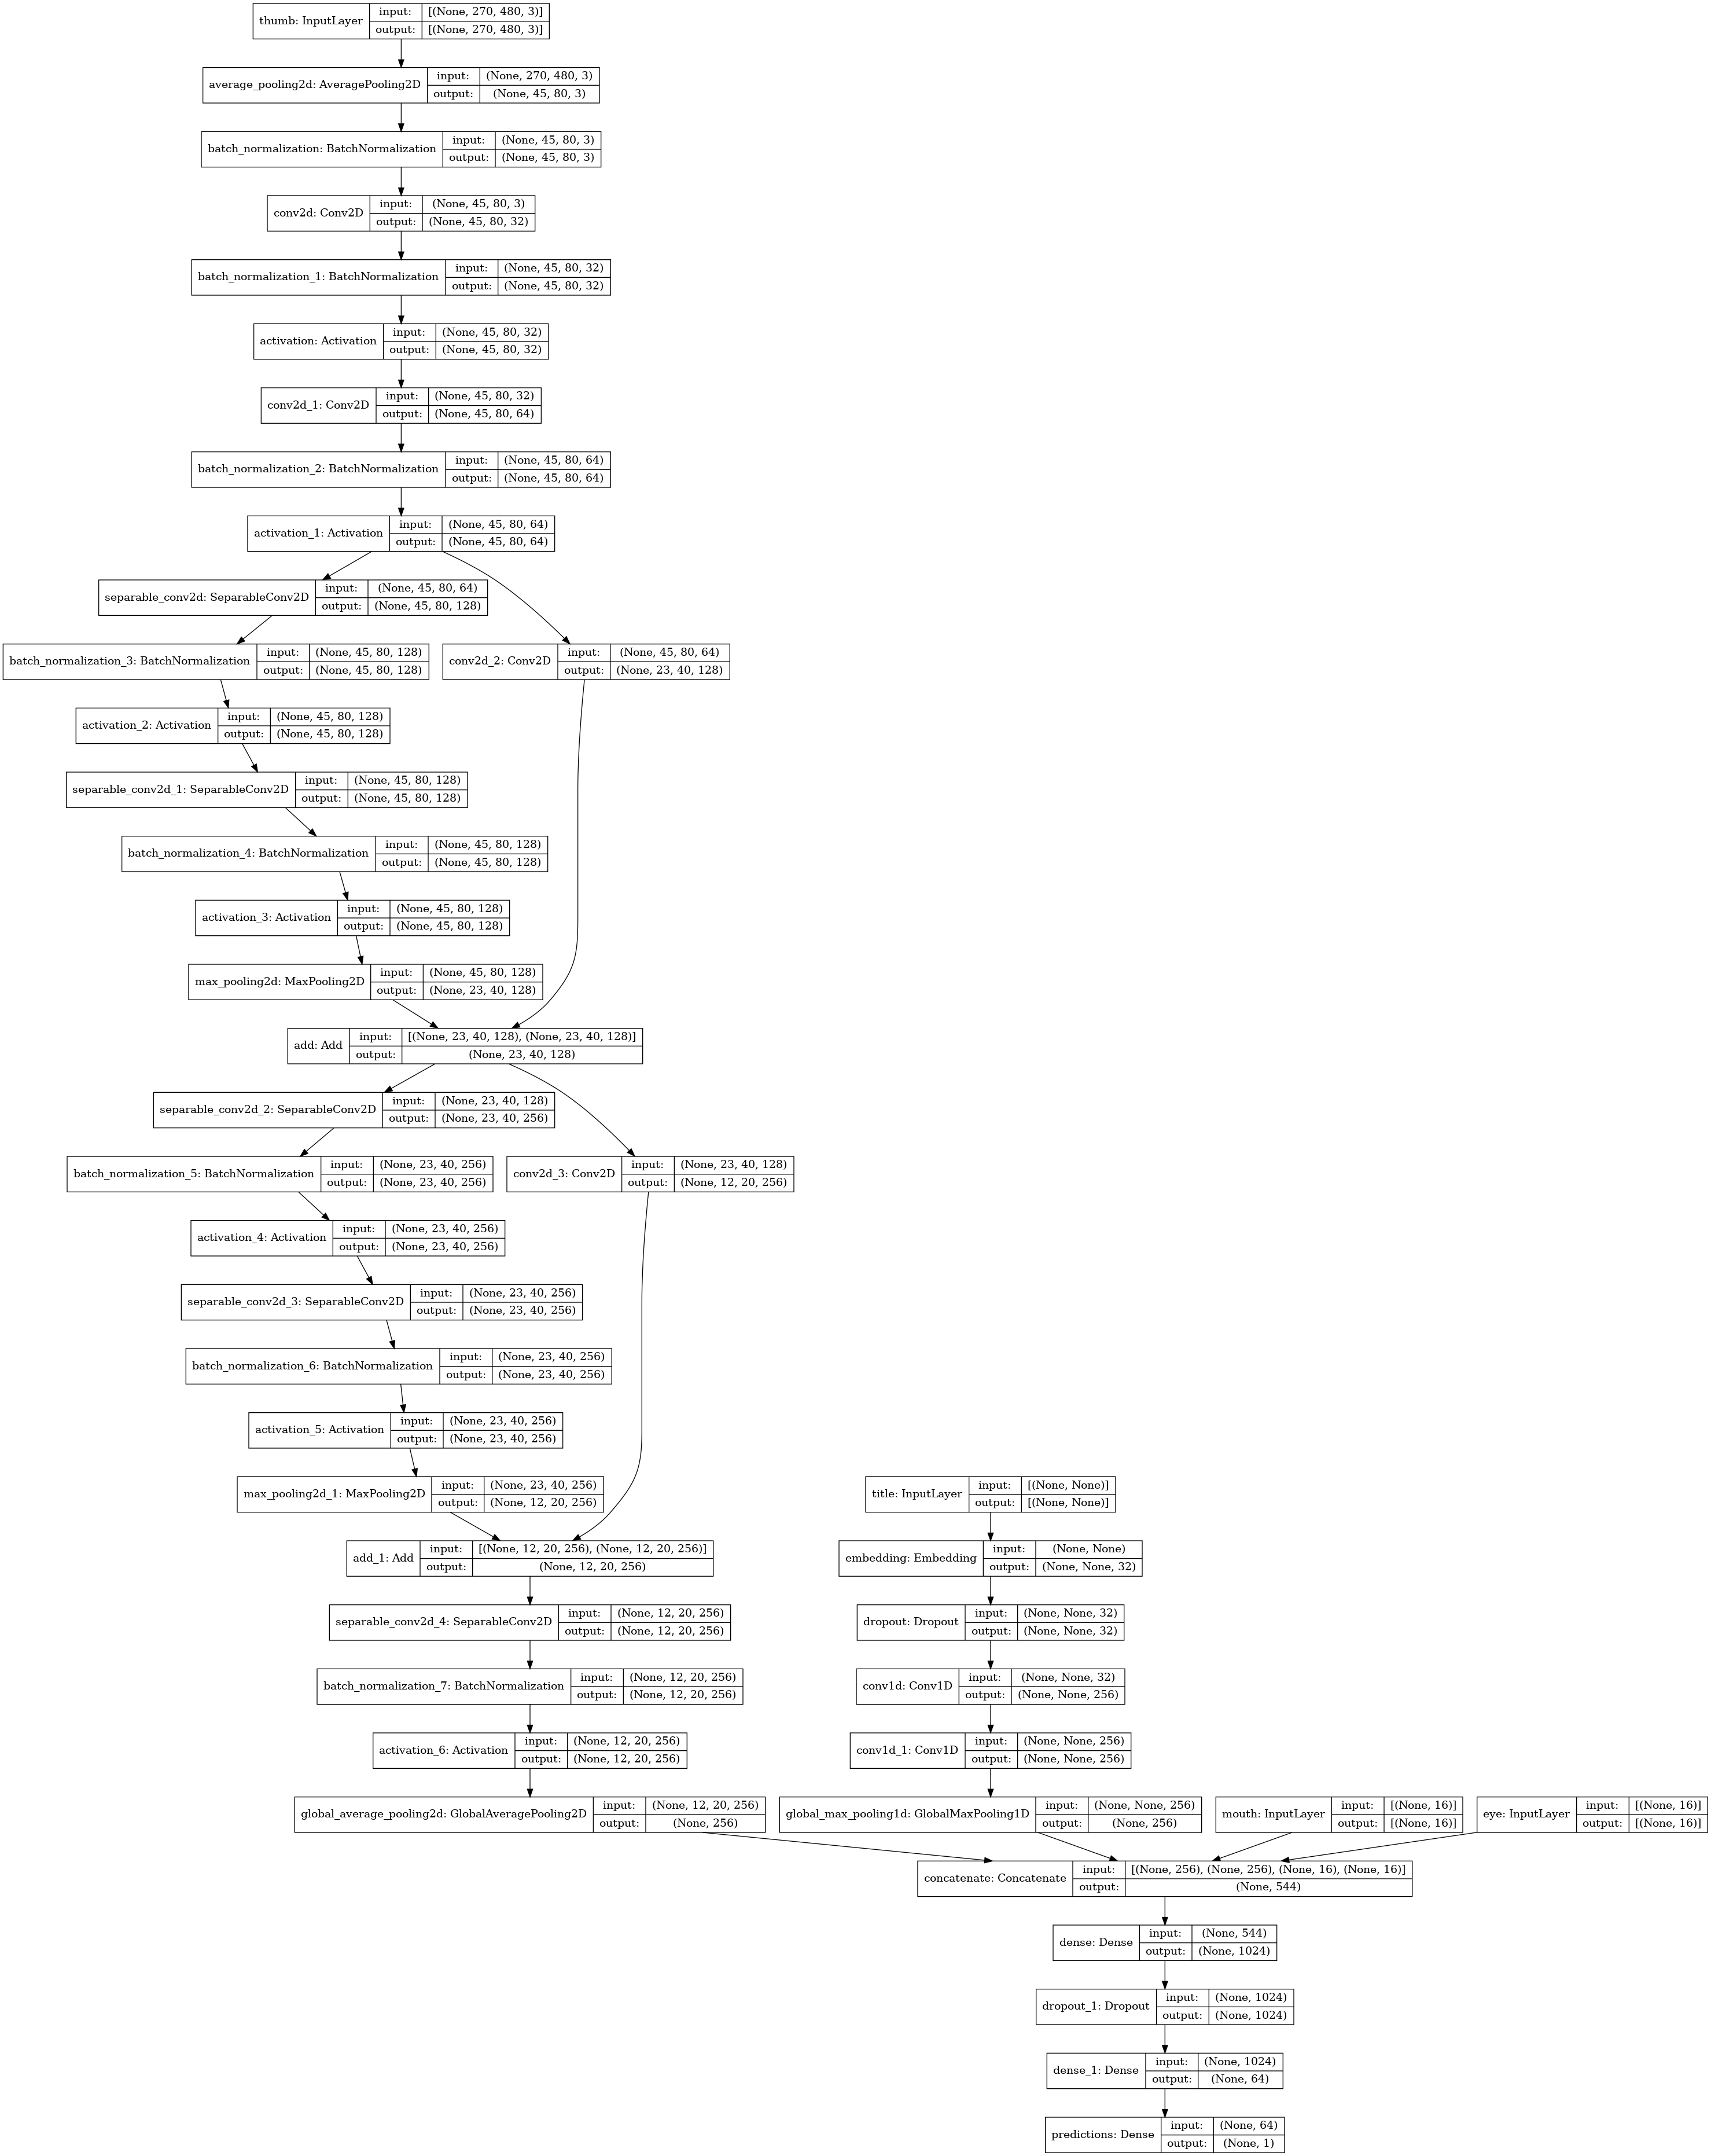

In [33]:
thumbnail_input=keras.Input(shape=(270,480,3),name='thumb')

#2d conv for thumbnail
x=layers.AveragePooling2D(6)(thumbnail_input)
x=layers.BatchNormalization()(x)

x=layers.Conv2D(filters=32,kernel_size=3,activation='relu',padding='same')(x)
x=layers.BatchNormalization()(x)
x=layers.Activation("relu")(x)

x=layers.Conv2D(filters=64,kernel_size=3,activation='relu',padding='same')(x)
x=layers.BatchNormalization()(x)
x=layers.Activation("relu")(x)

prev=x

for size in [128, 256]:
    x=layers.SeparableConv2D(size,3,padding="same")(x)
    x=layers.BatchNormalization()(x)
    x=layers.Activation("relu")(x)

    x=layers.SeparableConv2D(size,3,padding="same")(x)
    x=layers.BatchNormalization()(x)
    x=layers.Activation("relu")(x)

    x=layers.MaxPooling2D(3,strides=2,padding="same")(x)

    # Project residual
    residual = layers.Conv2D(size,1,strides=2,padding="same")(prev)
    
    x = layers.add([x,residual])  # Add back residual
    prev=x                        # Set aside next residual


x=layers.SeparableConv2D(256,3,padding="same")(x)
x=layers.BatchNormalization()(x)
x=layers.Activation("relu")(x)

flat=layers.GlobalAveragePooling2D()(x)

# A integer input for vocab indices.
inputs = tf.keras.Input(shape=(None,), dtype="int64",name="title")

# Next, we add a layer to map those vocab indices into a space of dimensionality
# 'embedding_dim'.
x = layers.Embedding(max_features, embedding_dim)(inputs)
x = layers.Dropout(0.7)(x)

# Conv1D + global max pooling
x = layers.Conv1D(256, 7, padding="valid", activation="relu", strides=2)(x)
x = layers.Conv1D(256, 7, padding="valid", activation="relu", strides=2)(x)
flat2 = layers.GlobalMaxPooling1D()(x)

#mouth and eye inputs
mouth_input=keras.Input(shape=(16),name="mouth")
eye_input=keras.Input(shape=(16),name="eye")

# We add a vanilla hidden layer:
flat_comb=layers.concatenate([flat,flat2,mouth_input,eye_input])
dense=layers.Dense(1024)(flat_comb)
x = layers.Dropout(0.5)(dense)

# We project onto a single unit output layer, and squash it with a sigmoid:
x = layers.Dense(64,activation="relu")(x)
predictions = layers.Dense(1, activation="sigmoid", name="predictions")(x)

model = tf.keras.Model([thumbnail_input,inputs,mouth_input,eye_input], predictions)

# Compile the model with binary crossentropy loss and an adam optimizer.
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["acc", precision_m, recall_m, f1_m])
plot_model(model,show_layer_names=1,show_shapes=True)

In [34]:
tf.keras.backend.clear_session()
model.fit(x=X_train,y=y_train,validation_split=0.2,
              epochs=10,batch_size=8)

Epoch 1/10
974/974 [==============================] - 32s 32ms/step - loss: 0.4800 - acc: 0.7576 - precision_m: 0.7084 - recall_m: 0.6650 - f1_m: 0.6541 - val_loss: 0.2252 - val_acc: 0.8973 - val_precision_m: 0.8395 - val_recall_m: 0.9496 - val_f1_m: 0.8767
Epoch 2/10
974/974 [==============================] - 31s 31ms/step - loss: 0.1818 - acc: 0.9219 - precision_m: 0.9016 - recall_m: 0.8948 - f1_m: 0.8849 - val_loss: 0.1750 - val_acc: 0.9276 - val_precision_m: 0.9391 - val_recall_m: 0.8890 - val_f1_m: 0.9017
Epoch 3/10
974/974 [==============================] - 31s 32ms/step - loss: 0.1333 - acc: 0.9483 - precision_m: 0.9319 - recall_m: 0.9342 - f1_m: 0.9241 - val_loss: 0.2038 - val_acc: 0.9271 - val_precision_m: 0.8963 - val_recall_m: 0.9401 - val_f1_m: 0.9050
Epoch 4/10
974/974 [==============================] - 32s 33ms/step - loss: 0.0929 - acc: 0.9662 - precision_m: 0.9567 - recall_m: 0.9545 - f1_m: 0.9497 - val_loss: 0.1656 - val_acc: 0.9374 - val_precision_m: 0.9410 - val_reca

## Testing on set beta1

In [27]:
X_test,y_test=get_io(s3)

In [28]:
def make_model(): #make a new copy of the model shown above
    thumbnail_input=keras.Input(shape=(270,480,3),name='thumb')

    #2d conv for thumbnail
    x=layers.AveragePooling2D(6)(thumbnail_input)
    x=layers.BatchNormalization()(x)

    x=layers.Conv2D(filters=32,kernel_size=3,activation='relu',padding='same')(x)
    x=layers.BatchNormalization()(x)
    x=layers.Activation("relu")(x)

    x=layers.Conv2D(filters=64,kernel_size=3,activation='relu',padding='same')(x)
    x=layers.BatchNormalization()(x)
    x=layers.Activation("relu")(x)

    prev=x

    for size in [128, 256]:
        x=layers.SeparableConv2D(size,3,padding="same")(x)
        x=layers.BatchNormalization()(x)
        x=layers.Activation("relu")(x)

        x=layers.SeparableConv2D(size,3,padding="same")(x)
        x=layers.BatchNormalization()(x)
        x=layers.Activation("relu")(x)

        x=layers.MaxPooling2D(3,strides=2,padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size,1,strides=2,padding="same")(prev)

        x = layers.add([x,residual])  # Add back residual
        prev=x                        # Set aside next residual


    x=layers.SeparableConv2D(256,3,padding="same")(x)
    x=layers.BatchNormalization()(x)
    x=layers.Activation("relu")(x)

    flat=layers.GlobalAveragePooling2D()(x)

    # A integer input for vocab indices.
    inputs = tf.keras.Input(shape=(None,), dtype="int64",name="title")

    # Next, we add a layer to map those vocab indices into a space of dimensionality
    # 'embedding_dim'.
    x = layers.Embedding(max_features, embedding_dim)(inputs)
    x = layers.Dropout(0.7)(x)

    # Conv1D + global max pooling
    x = layers.Conv1D(256, 7, padding="valid", activation="relu", strides=2)(x)
    x = layers.Conv1D(256, 7, padding="valid", activation="relu", strides=2)(x)
    flat2 = layers.GlobalMaxPooling1D()(x)

    #mouth and eye inputs
    mouth_input=keras.Input(shape=(16),name="mouth")
    eye_input=keras.Input(shape=(16),name="eye")

    # We add a vanilla hidden layer:
    flat_comb=layers.concatenate([flat,flat2,mouth_input,eye_input])
    dense=layers.Dense(1024)(flat_comb)
    x = layers.Dropout(0.5)(dense)

    # We project onto a single unit output layer, and squash it with a sigmoid:
    x = layers.Dense(64,activation="relu")(x)
    predictions = layers.Dense(1, activation="sigmoid", name="predictions")(x)

    model = tf.keras.Model([thumbnail_input,inputs,mouth_input,eye_input], predictions)

    # Compile the model with binary crossentropy loss and an adam optimizer.
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["acc", precision_m, recall_m, f1_m])
    plot_model(model,show_layer_names=1,show_shapes=True)
    
    return model

We will train with datasets alpha and beta0, with testing on beta1.

Since dataset alpha has noisy results, we want the model to learn more from dataset beta0. To solve this problem, we will add $K$ copies of dataset beta0 into our training set, so that our model is more skewed towards dataset beta0. We will do a parameter sweep of all $K$ in $\{1,2,4,6,8\}$.

In [32]:
val_f1=[]
ks=[1,2,4,6,8]

for k in ks:
    print("current K: ",k)
    
    model=make_model()
    ids=pd.concat([s]+[s2]*k) #concatenate
    X_train,y_train=get_io(ids)

    tf.keras.backend.clear_session()
    hist=model.fit(x=X_train,y=y_train,validation_data=(X_test,y_test),
                  epochs=10,batch_size=8)
    
    val_f1.append(max(hist.history["val_f1_m"]))
    
    #free up memory
    del X_train
    del y_train
    print("\n\n")

current K:  1
Epoch 1/10
1239/1239 [==============================] - 133s 106ms/step - loss: 0.4723 - acc: 0.7599 - precision_m: 0.7186 - recall_m: 0.6932 - f1_m: 0.6664 - val_loss: 0.6310 - val_acc: 0.7588 - val_precision_m: 0.5040 - val_recall_m: 0.6341 - val_f1_m: 0.5176
Epoch 2/10
1239/1239 [==============================] - 36s 29ms/step - loss: 0.1838 - acc: 0.9270 - precision_m: 0.9112 - recall_m: 0.9024 - f1_m: 0.8915 - val_loss: 0.6274 - val_acc: 0.8000 - val_precision_m: 0.6169 - val_recall_m: 0.6379 - val_f1_m: 0.5890
Epoch 3/10
1239/1239 [==============================] - 37s 30ms/step - loss: 0.1238 - acc: 0.9510 - precision_m: 0.9389 - recall_m: 0.9355 - f1_m: 0.9278 - val_loss: 0.7639 - val_acc: 0.8059 - val_precision_m: 0.6555 - val_recall_m: 0.7023 - val_f1_m: 0.6339
Epoch 4/10
1239/1239 [==============================] - 37s 30ms/step - loss: 0.1065 - acc: 0.9586 - precision_m: 0.9469 - recall_m: 0.9475 - f1_m: 0.9393 - val_loss: 0.6527 - val_acc: 0.8000 - val_precis

1345/1345 [==============================] - 36s 27ms/step - loss: 0.1841 - acc: 0.9283 - precision_m: 0.9160 - recall_m: 0.8963 - f1_m: 0.8931 - val_loss: 0.4783 - val_acc: 0.8235 - val_precision_m: 0.5727 - val_recall_m: 0.5303 - val_f1_m: 0.5086
Epoch 3/10
1345/1345 [==============================] - 37s 27ms/step - loss: 0.1343 - acc: 0.9478 - precision_m: 0.9271 - recall_m: 0.9301 - f1_m: 0.9187 - val_loss: 0.7466 - val_acc: 0.7824 - val_precision_m: 0.5722 - val_recall_m: 0.7894 - val_f1_m: 0.6073
Epoch 4/10
1345/1345 [==============================] - 37s 28ms/step - loss: 0.0939 - acc: 0.9634 - precision_m: 0.9464 - recall_m: 0.9462 - f1_m: 0.9389 - val_loss: 0.8062 - val_acc: 0.8176 - val_precision_m: 0.6068 - val_recall_m: 0.6189 - val_f1_m: 0.5722
Epoch 5/10
1345/1345 [==============================] - 38s 29ms/step - loss: 0.1070 - acc: 0.9605 - precision_m: 0.9463 - recall_m: 0.9462 - f1_m: 0.9394 - val_loss: 0.6282 - val_acc: 0.8176 - val_precision_m: 0.6038 - val_recall_

In [40]:
val_f1

[0.6338515281677246,
 0.6834054589271545,
 0.6659812927246094,
 0.6751081943511963,
 0.6815295815467834]

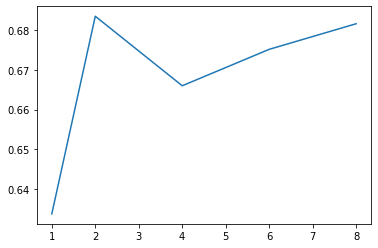

In [37]:
plt.plot(ks,val_f1)